In [67]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn
import random
import numpy as np
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

# 상수 정의 부분에 추가
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]


In [68]:
import os
import sys

# 본 과제 제출자는 현재 우분투 도커 환경에서 작업중이므로 다음과 같이 경로 설정
BASE_PATH="/home/Deep-Learning-study"
import sys
sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows
num_data_loading_workers = 4

In [69]:
def calculate_mean_std(train_loader):
    """
    데이터셋의 mean과 std를 계산하는 함수
    
    Args:
        train_loader (DataLoader): 학습 데이터셋의 DataLoader 객체
        
    Returns:
        tuple: (mean, std) - 계산된 평균과 표준편차 값
    """
    mean = 0.
    std = 0.
    total_images = 0
    
    print("Calculating dataset statistics...")
    print("This may take a moment...")
    
    # Step 1: 평균(mean) 계산
    for images, _ in train_loader:
        # batch_samples: 현재 배치의 이미지 개수
        batch_samples = images.size(0)
        # images shape 변경: [batch_size, channels, height, width] -> [batch_size, channels, height*width]
        images = images.view(batch_samples, images.size(1), -1)
        # 각 채널별 평균 계산 후 배치의 합 누적
        mean += images.mean(2).sum(0)  # dim=2는 height*width 차원에 대한 평균
        total_images += batch_samples
    
    # 전체 이미지 수로 나누어 최종 평균 계산
    mean /= total_images
    
    # Step 2: 분산(variance) 계산
    var = 0.
    for images, _ in train_loader:
        batch_samples = images.size(0)
        # 이미지 shape 변경
        images = images.view(batch_samples, images.size(1), -1)
        # 각 픽셀값에서 평균을 뺀 후 제곱하여 분산 계산
        # mean.unsqueeze(1): mean을 [channels, 1]로 확장하여 broadcasting 가능하게 함
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])  # [0,2]는 batch와 height*width 차원
    
    # 표준편차 계산: 분산의 제곱근
    # total_images * 28 * 28: 전체 픽셀 수
    std = torch.sqrt(var / (total_images * 28 * 28))
    
    # 계산된 통계값 출력
    print("\nDataset Statistics:")
    print(f"Number of training images: {total_images}")
    print(f"Mean: {mean.item():.4f}")  # .item()으로 텐서값을 파이썬 스칼라로 변환
    print(f"Std: {std.item():.4f}")
    print(f"Var: {std.item()**2:.4f}")
    
    # wandb에 계산된 통계값 기록 (wandb 실행 중일 때만)
    if wandb.run is not None:
        wandb.run.summary.update({
            "dataset_mean": mean.item(),
            "dataset_std": std.item(),
            "dataset_variance": std.item()**2
        })
    
    return mean.item(), std.item()

In [70]:
def get_fashion_mnist_data():
    """
    Fashion MNIST 데이터셋의 학습 및 검증용 데이터 로더를 생성하는 함수
    
    Returns:
        tuple: (train_data_loader, validation_data_loader, val_transform)
            - train_data_loader: 학습용 데이터 로더
            - validation_data_loader: 검증용 데이터 로더
            - val_transform: 검증/테스트에 사용할 transform
    """
    # 데이터셋 저장 경로 설정
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    print("\nLoading Fashion MNIST dataset...")
    
    # Step 1: 통계 계산을 위한 초기 데이터셋 로드
    # ToTensor()만 적용하여 픽셀값을 0~1 범위로 정규화
    f_mnist_train = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # Step 2: 데이터셋 통계(mean, std) 계산을 위한 임시 데이터 로더
    # batch_size=1000으로 메모리 사용량 조절
    temp_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=1000,
        shuffle=False,  # 통계 계산시 순서 무관
        num_workers=num_data_loading_workers  # 병렬 처리
    )
    
    # Step 3: 데이터셋의 평균과 표준편차 계산
    mean, std = calculate_mean_std(temp_loader)
    
    print("\nApplying calculated normalization values:")
    print(f"Mean: {mean:.4f}")
    print(f"Std: {std:.4f}")
    
    # Step 4: 학습용 transform 정의 (데이터 증강 포함)
    train_transform = transforms.Compose([
        # 50% 확률로 이미지 좌우 반전
        transforms.RandomHorizontalFlip(p=0.5),
        # ±10도 범위에서 랜덤 회전
        transforms.RandomRotation(10),
        # 이미지 변형: 이동 및 크기 조정
        transforms.RandomAffine(
            degrees=0,  # 추가 회전 없음
            translate=(0.1, 0.1),  # 10% 범위 내 랜덤 이동
            scale=(0.9, 1.1)  # 90%~110% 범위 내 크기 조정
        ),
        transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
        transforms.Normalize(mean=mean, std=std)  # 계산된 통계값으로 정규화
    ])
    
    # Step 5: 검증용 transform 정의 (데이터 증강 제외)
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # Step 6: transform이 적용된 데이터셋 재생성
    f_mnist_train = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=train_transform
    )

    f_mnist_validation = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=val_transform
    )

    # Step 7: 학습/검증 데이터 분할
    # 전체 60,000개 중 55,000개는 학습용, 5,000개는 검증용
    train_indices = range(0, 55_000)
    validation_indices = range(55_000, 60_000)

    f_mnist_train = torch.utils.data.Subset(f_mnist_train, train_indices)
    f_mnist_validation = torch.utils.data.Subset(f_mnist_validation, validation_indices)

    # Step 8: DataLoader 생성
    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,  # 학습 시 데이터 순서 섞기
        pin_memory=True,  # GPU 메모리 전송 최적화
        num_workers=num_data_loading_workers  # 병렬 데이터 로딩
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_data_loading_workers
    )

    # 데이터 로더와 검증용 transform 반환
    return train_data_loader, validation_data_loader, val_transform

In [71]:
def get_fashion_mnist_test_data(batch_size=128):
    """
    Fashion MNIST 테스트 데이터셋을 위한 데이터 로더를 생성하는 함수
    
    Args:
        batch_size (int): 배치 크기 (기본값: 128)
        
    Returns:
        tuple: (f_mnist_test_images, test_data_loader, transform)
            - f_mnist_test_images: 원본 테스트 이미지 (시각화용)
            - test_data_loader: 정규화된 테스트 데이터 로더
            - transform: 테스트 데이터에 적용된 transform
    """
    # 데이터셋 저장 경로 설정
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")
    
    # Step 1: 테스트용 transform 정의
    # 데이터 증강은 제외하고 기본적인 정규화만 적용
    transform = transforms.Compose([
        transforms.ToTensor(),  # PIL 이미지를 텐서로 변환 (0~1 범위로 정규화)
        transforms.Normalize(
            mean=0.2860,  # 학습 데이터에서 계산된 평균값
            std=0.3530    # 학습 데이터에서 계산된 표준편차값
        )
    ])

    # Step 2: 원본 테스트 이미지 로드 (시각화용)
    # transform을 적용하지 않은 원본 상태로 저장
    f_mnist_test_images = datasets.FashionMNIST(
        data_path,        # 데이터 저장 경로
        train=False,      # 테스트 데이터셋 사용
        download=True     # 필요시 데이터 다운로드
    )

    # Step 3: 정규화된 테스트 데이터셋 생성
    # 모델 평가에 사용할 정규화된 버전
    f_mnist_test = datasets.FashionMNIST(
        data_path,
        train=False,
        download=True,
        transform=transform  # 정규화 transform 적용
    )

    # Step 4: 테스트 데이터 로더 생성
    test_data_loader = DataLoader(
        dataset=f_mnist_test,
        batch_size=batch_size,      # 지정된 배치 크기 사용
        pin_memory=True,            # GPU 메모리 전송 최적화
        num_workers=num_data_loading_workers  # 병렬 데이터 로딩
    )

    # 원본 이미지, 정규화된 데이터 로더, transform 반환
    return f_mnist_test_images, test_data_loader, transform

In [72]:
# 실험의 재현성을 위한 랜덤 시드 설정 함수
def set_seed(seed=42):
    """
    모든 랜덤 생성기에 대한 시드를 설정하는 함수
    
    Args:
        seed (int): 설정할 랜덤 시드 값 (기본값: 42)
    """
    torch.manual_seed(seed)          # PyTorch CPU 연산의 랜덤 시드 설정
    torch.cuda.manual_seed_all(seed) # PyTorch GPU 연산의 랜덤 시드 설정
    np.random.seed(seed)            # NumPy 랜덤 시드 설정
    random.seed(seed)               # Python 기본 랜덤 시드 설정

class FashionMNISTResNet(nn.Module):
    """
    Fashion MNIST 데이터셋을 위해 수정된 ResNet18 모델
    
    특징:
    - 그레이스케일 이미지 입력 처리 (1채널)
    - 28x28 크기의 작은 이미지에 최적화
    - 10개 클래스 분류를 위한 출력층
    """
    def __init__(self):
        """
        모델 구조 초기화
        """
        super().__init__()
        # ImageNet으로 사전 학습된 ResNet18 모델 로드
        self.model = models.resnet18(pretrained=True)
        
        # 입력층 수정
        # - in_channels=1: 그레이스케일 이미지 처리
        # - out_channels=64: ResNet 구조 유지
        # - kernel_size=3: 작은 이미지에 적합한 커널 크기
        # - stride=1: 작은 이미지의 특징 보존
        # - padding=1: 입력 크기 유지
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        
        # maxpool 레이어 제거
        # - 28x28 크기의 작은 이미지에서는 초기 다운샘플링이 불필요
        # - Identity()를 사용하여 입력을 그대로 통과
        self.model.maxpool = nn.Identity()
        
        # 출력층 수정
        # - Dropout(0.5): 과적합 방지
        # - Linear(..., 10): Fashion MNIST의 10개 클래스 출력
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),  # 50% 드롭아웃으로 과적합 방지
            nn.Linear(self.model.fc.in_features, 10)  # 10개 클래스로 출력
        )
        
    def forward(self, x):
        """
        순전파 연산 정의
        
        Args:
            x (torch.Tensor): 입력 이미지 배치
            
        Returns:
            torch.Tensor: 각 클래스에 대한 예측 점수
        """
        return self.model(x)

In [73]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    한 에포크 동안의 모델 학습을 수행하는 함수
    
    Args:
        model (nn.Module): 학습할 모델
        train_loader (DataLoader): 학습 데이터 로더
        criterion: 손실 함수 (예: CrossEntropyLoss)
        optimizer: 옵티마이저 (예: Adam)
        device: 학습에 사용할 디바이스 (cuda 또는 cpu)
    
    Returns:
        tuple: (average_loss, accuracy)
            - average_loss (float): 에포크의 평균 손실값
            - accuracy (float): 에포크의 정확도 (백분율)
    """
    # 모델을 학습 모드로 설정
    model.train()
    
    # 손실값과 정확도 계산을 위한 변수 초기화
    running_loss = 0.0  # 누적 손실값
    correct = 0         # 정확히 예측한 샘플 수
    total = 0          # 전체 샘플 수
    
    # 미니배치 단위로 학습 수행
    for inputs, labels in train_loader:
        # 데이터를 지정된 디바이스로 이동
        inputs = inputs.to(device)   # 입력 이미지
        labels = labels.to(device)   # 정답 레이블
        
        # 1. 그래디언트 초기화
        optimizer.zero_grad()
        
        # 2. 순전파 (forward pass)
        outputs = model(inputs)
        
        # 3. 손실 계산
        loss = criterion(outputs, labels)
        
        # 4. 역전파 (backward pass)
        loss.backward()
        
        # 5. 가중치 업데이트
        optimizer.step()
        
        # 통계 업데이트
        running_loss += loss.item()                      # 배치의 손실값 누적
        _, predicted = outputs.max(1)                    # 가장 높은 확률의 클래스 선택
        total += labels.size(0)                         # 배치 크기만큼 전체 개수 증가
        correct += predicted.eq(labels).sum().item()    # 정확히 예측한 개수 계산
    
    # 평균 손실값과 정확도 반환
    avg_loss = running_loss / len(train_loader)  # 전체 배치에 대한 평균 손실
    accuracy = 100. * correct / total            # 정확도를 백분율로 계산
    
    return avg_loss, accuracy

In [74]:
def validate(model, val_loader, criterion, device):
    """
    검증 데이터셋에서 모델의 성능을 평가하는 함수
    
    Args:
        model (nn.Module): 평가할 모델
        val_loader (DataLoader): 검증 데이터 로더
        criterion: 손실 함수 (예: CrossEntropyLoss)
        device: 평가에 사용할 디바이스 (cuda 또는 cpu)
    
    Returns:
        tuple: (average_loss, accuracy)
            - average_loss (float): 검증 세트의 평균 손실값
            - accuracy (float): 검증 세트의 정확도 (백분율)
    """
    # 모델을 평가 모드로 설정
    # - dropout과 batch normalization이 평가 모드로 변경됨
    model.eval()
    
    # 성능 측정을 위한 변수 초기화
    running_loss = 0.0  # 누적 손실값
    correct = 0         # 정확히 예측한 샘플 수
    total = 0          # 전체 샘플 수
    
    # 그래디언트 계산 비활성화
    # - 검증 시에는 가중치 업데이트가 필요 없음
    # - 메모리 사용량 감소 및 연산 속도 향상
    with torch.no_grad():
        # 미니배치 단위로 검증 수행
        for inputs, labels in val_loader:
            # 데이터를 지정된 디바이스로 이동
            inputs = inputs.to(device)   # 입력 이미지
            labels = labels.to(device)   # 정답 레이블
            
            # 1. 순전파 (forward pass)
            outputs = model(inputs)
            
            # 2. 손실 계산
            loss = criterion(outputs, labels)
            
            # 통계 업데이트
            running_loss += loss.item()                      # 배치의 손실값 누적
            _, predicted = outputs.max(1)                    # 가장 높은 확률의 클래스 선택
            total += labels.size(0)                         # 배치 크기만큼 전체 개수 증가
            correct += predicted.eq(labels).sum().item()    # 정확히 예측한 개수 계산
    
    # 평균 손실값과 정확도 반환
    avg_loss = running_loss / len(val_loader)  # 전체 배치에 대한 평균 손실
    accuracy = 100. * correct / total          # 정확도를 백분율로 계산
    
    return avg_loss, accuracy

In [75]:
def test_model(model, device):
    """
    학습이 완료된 모델의 최종 성능을 테스트 데이터셋에서 평가하는 함수
    
    Args:
        model (nn.Module): 평가할 모델
        device: 평가에 사용할 디바이스 (cuda 또는 cpu)
    
    Returns:
        float: 테스트 데이터셋에 대한 정확도 (백분율)
    """
    # 모델을 평가 모드로 설정
    # - dropout과 batch normalization이 평가 모드로 변경됨
    model.eval()
    
    # 테스트 데이터 로드
    # - test_images: 원본 이미지 (시각화용)
    # - test_loader: 정규화된 데이터 로더
    # - _: transform (사용하지 않음)
    test_images, test_loader, _ = get_fashion_mnist_test_data(batch_size=128)
    
    # 성능 측정을 위한 변수 초기화
    correct = 0  # 정확히 예측한 샘플 수
    total = 0    # 전체 샘플 수
    
    # 그래디언트 계산 비활성화
    # - 테스트 시에는 가중치 업데이트가 필요 없음
    # - 메모리 사용량 감소 및 연산 속도 향상
    with torch.no_grad():
        # 미니배치 단위로 테스트 수행
        for images, labels in test_loader:
            # 데이터를 지정된 디바이스로 이동
            images = images.to(device)  # 입력 이미지
            labels = labels.to(device)  # 정답 레이블
            
            # 모델 예측 수행
            outputs = model(images)
            
            # 가장 높은 확률의 클래스 선택
            _, predicted = torch.max(outputs.data, 1)
            
            # 통계 업데이트
            total += labels.size(0)                    # 배치 크기만큼 전체 개수 증가
            correct += (predicted == labels).sum().item()  # 정확히 예측한 개수 계산
    
    # 최종 정확도 계산 (백분율)
    test_accuracy = 100 * correct / total
    
    # 결과 출력
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # wandb에 테스트 결과 기록 (wandb 실행 중인 경우에만)
    if wandb.run is not None:
        wandb.run.summary["test_accuracy"] = test_accuracy
    
    return test_accuracy

In [76]:
def main():
    """
    Fashion MNIST 분류 모델의 전체 학습 파이프라인을 관리하는 메인 함수
    
    Returns:
        nn.Module: 학습된 모델
    """
    # 재현성을 위한 랜덤 시드 설정
    set_seed()
    
    # 학습에 사용할 디바이스 설정 (GPU/CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Step 1: wandb 설정
    wandb.login()
    wandb.init(
        project="fashion-mnist-resnet",
        name="resnet18_fashion_mnist",
        config={
            "architecture": "ResNet18",
            "learning_rate": 1e-3,        # 초기 학습률
            "batch_size": 128,            # 배치 크기
            "epochs": 20,                 # 총 에포크 수
            "weight_decay": 1e-4,         # L2 정규화 강도
            "early_stop_patience": 7,      # 조기 종료 인내심
            "optimizer": "AdamW",         # 사용할 옵티마이저
            "scheduler": "ReduceLROnPlateau",  # 학습률 스케줄러
            "dataset": "Fashion MNIST"     # 데이터셋 이름
        }
    )
    config = wandb.config
    
    # Step 2: 데이터 준비
    train_loader, val_loader, transforms = get_fashion_mnist_data()
    
    # Step 3: 모델 초기화 및 설정
    model = FashionMNISTResNet().to(device)
    summary(model, input_size=(1, 1, 28, 28))  # 모델 구조 출력
    wandb.watch(model, log="all", log_freq=100)  # wandb 모델 모니터링
    
    # Step 4: 학습 도구 설정
    criterion = nn.CrossEntropyLoss()  # 손실 함수
    optimizer = torch.optim.AdamW(     # 옵티마이저
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(  # 학습률 조정기
        optimizer, mode='max', factor=0.1, patience=3, verbose=True
    )
    
    # Step 5: wandb 진행 상황 테이블 설정
    columns = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
    progress_table = wandb.Table(columns=columns)
    
    # Step 6: Early Stopping 초기화
    best_val_acc = 0
    patience_counter = 0
    
    # Step 7: 학습 루프
    for epoch in range(config.epochs):
        # 7.1 학습 단계
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 7.2 검증 단계
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # 7.3 학습률 업데이트
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        
        # 7.4 wandb 로깅
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": current_lr
        })
        
        # 7.5 진행 상황 출력
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr}")
        
        # 7.6 Early Stopping 및 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            # 최고 성능 모델 저장
            model_path = os.path.join(wandb.run.dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, model_path)
            wandb.save('best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        # Early stopping 체크
        if patience_counter >= config.early_stop_patience:
            print("Early stopping triggered")
            break
    
    # Step 8: 최종 결과 기록
    wandb.run.summary["best_validation_accuracy"] = best_val_acc
    
    # Step 9: 테스트 세트 평가
    print("\nEvaluating on test set...")
    test_acc = test_model(model, device)
    wandb.run.summary["test_accuracy"] = test_acc
    
    return model

In [79]:
def visualize_predictions(model, device, num_samples=10):
    """
    테스트 데이터셋에서 모델의 예측 결과를 시각화하는 함수
    
    Args:
        model (nn.Module): 평가할 모델
        device: 평가에 사용할 디바이스 (cuda 또는 cpu)
        num_samples (int): 시각화할 샘플 수 (기본값: 10)
    
    특징:
        - 최소 1개의 틀린 예측을 포함하여 시각화
        - 나머지는 올바른 예측으로 구성
        - 틀린 예측에 대한 상세 분석 제공
    """
    # Step 1: 데이터 준비
    test_images, test_loader, _ = get_fashion_mnist_test_data()
    model.eval()  # 모델을 평가 모드로 설정
    
    # Step 2: 데이터 전처리를 위한 transform 정의
    transform = transforms.Compose([
        transforms.ToTensor(),  # PIL 이미지를 텐서로 변환
        transforms.Normalize(mean=0.2860, std=0.3530)  # 학습 시와 동일한 정규화 적용
    ])
    
    # Step 3: 틀린 예측과 올바른 예측 찾기
    wrong_predictions = []    # 틀린 예측의 인덱스 저장
    correct_predictions = []  # 올바른 예측의 인덱스 저장
    
    with torch.no_grad():  # 메모리 효율성을 위해 그래디언트 계산 비활성화
        for idx in range(len(test_images)):
            # 이미지 전처리 및 예측
            image, label = test_images[idx]
            image_tensor = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가
            output = model(image_tensor)
            pred = output.argmax(dim=1).item()
            
            # 예측 결과에 따라 분류
            if pred != label:
                wrong_predictions.append(idx)
            else:
                correct_predictions.append(idx)
            
            # 충분한 틀린 예측을 찾으면 중단
            if len(wrong_predictions) >= 3:
                break
    
    # Step 4: 시각화할 샘플 선택
    selected_indices = [wrong_predictions[0]]  # 틀린 예측 1개 포함
    remaining_samples = num_samples - 1
    selected_indices.extend(random.sample(correct_predictions, remaining_samples))
    random.shuffle(selected_indices)  # 랜덤 순서로 배치
    
    # Step 5: 시각화
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2x5 그리드 생성
    axes = axes.ravel()  # 2D 배열을 1D로 변환
    
    for idx, sample_idx in enumerate(selected_indices):
        # 이미지 로드 및 예측
        image, label = test_images[sample_idx]
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image_tensor)
            pred = output.argmax(dim=1).item()
        
        # 이미지 및 예측 결과 표시
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        title = f'True: {class_names[label]}\nPred: {class_names[pred]}'
        color = 'green' if pred == label else 'red'
        axes[idx].set_title(title, color=color)
        
        # 틀린 예측에 대한 상세 분석
        if pred != label:
            print(f"\n틀린 예측 분석:")
            print(f"실제 클래스: {class_names[label]}")
            print(f"예측 클래스: {class_names[pred]}")

    
    plt.tight_layout()
    plt.show()
    
    # Step 6: 시각화된 샘플들의 정확도 계산 및 출력
    correct = sum(1 for idx in selected_indices if 
                 model(transform(test_images[idx][0]).unsqueeze(0).to(device)).argmax(dim=1).item() == test_images[idx][1])
    print(f"\nVisualization Accuracy: {correct/num_samples*100:.2f}% ({correct}/{num_samples} correct)")


Loading Fashion MNIST dataset...
Calculating dataset statistics...
This may take a moment...

Dataset Statistics:
Number of training images: 60000
Mean: 0.2860
Std: 0.3530
Var: 0.1246

Applying calculated normalization values:
Mean: 0.2860
Std: 0.3530


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20
Train Loss: 0.4588, Train Acc: 83.56%
Val Loss: 0.3315, Val Acc: 87.96%
Learning Rate: 0.001
Epoch 2/20
Train Loss: 0.3241, Train Acc: 88.27%
Val Loss: 0.2411, Val Acc: 90.92%
Learning Rate: 0.001
Epoch 3/20
Train Loss: 0.2868, Train Acc: 89.68%
Val Loss: 0.2253, Val Acc: 91.12%
Learning Rate: 0.001
Epoch 4/20
Train Loss: 0.2630, Train Acc: 90.63%
Val Loss: 0.2050, Val Acc: 92.50%
Learning Rate: 0.001
Epoch 5/20
Train Loss: 0.2483, Train Acc: 91.20%
Val Loss: 0.2044, Val Acc: 92.46%
Learning Rate: 0.001
Epoch 6/20
Train Loss: 0.2356, Train Acc: 91.60%
Val Loss: 0.1917, Val Acc: 92.76%
Learning Rate: 0.001
Epoch 7/20
Train Loss: 0.2242, Train Acc: 91.83%
Val Loss: 0.1753, Val Acc: 93.58%
Learning Rate: 0.001
Epoch 8/20
Train Loss: 0.2168, Train Acc: 92.12%
Val Loss: 0.1777, Val Acc: 93.76%
Learning Rate: 0.001
Epoch 9/20
Train Loss: 0.2106, Train Acc: 92.41%
Val Loss: 0.1600, Val Acc: 94.06%
Learning Rate: 0.001
Epoch 10/20
Train Loss: 0.2046, Train Acc: 92.63%
Val Loss: 0.16

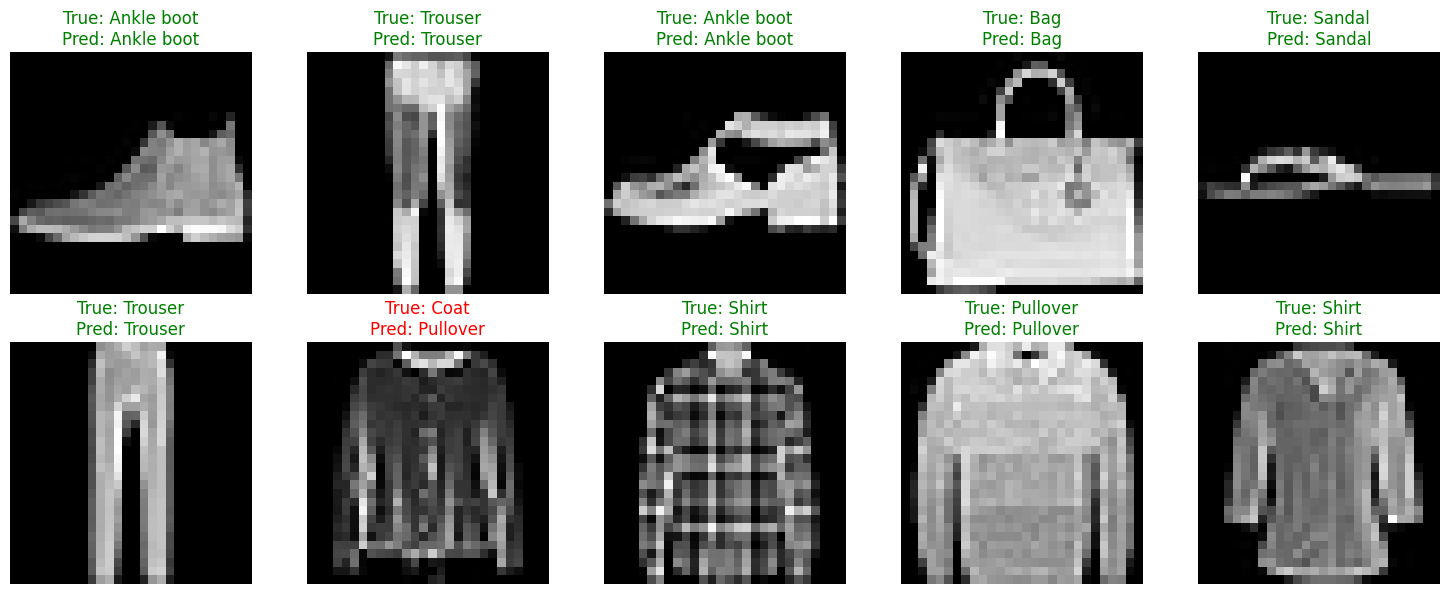


Visualization Accuracy: 90.00% (9/10 correct)


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇█▇████
train_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▄▄▅▅▆▆▇▇▇▆▆▇▇▇▇▇▇▇█
val_loss,█▅▄▃▃▃▂▂▂▂▃▂▁▁▂▂▁▂▁▁
best_validation_accuracy,95.14
dataset_mean,0.28604
dataset_std,0.35302
dataset_variance,0.12463
epoch,19


In [80]:
if __name__ == "__main__":    
    try:
        model = main()
        test_model(model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        visualize_predictions(model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    finally:
        wandb.finish()  # 모든 작업이 끝난 후에 wandb 종료

이미지의 각 라벨에 대한 패턴이 유사하거나 그레이스케일 변환을 통해, 그 구분이 더욱 힘들어져 잘못 구분 하였다고 판단됩니다.

코드 후기

resnet18을 imagenet으로 pretrained 된 모델을 로드하여 fashion mnist 데이터셋에 적합하게
변경함으로써 더욱 많은 경험을 할 수 있었습니다. 특히 pretrained 된 모델이여서 어느정도 잘
학습이 될것이라 예상하여 데이터 augmentation을 하지 않았는데, test accuracy가 원하는 수치만큼
나오지 않아 의외라 생각하였습니다. 추후 augmentation을 진행하고 나서 원하는 accuracy가 나오는것을 보고
역시 이러한 기술이 나온 배경이 명확하다라고 느끼게 되었습니다.